Project root: c:\Users\zklu8\Documents\COMP 576\Portfolio-Allocator
log_returns shape: (5031, 4)
Train / Val / Test sizes: 3018 1006 1007

Baseline final values on VALIDATION period:
  Buy & Hold SPY final value:   1.7874
  Equal-weight final value:      1.4597

Training history tail:


,episode,train_ep_return,val_final_value,steps
195,196,1.797478,1.301988,750
196,197,1.611414,1.594383,750
197,198,0.449837,1.283380,750
198,199,0.222141,1.732220,750
199,200,0.005076,1.710258,750


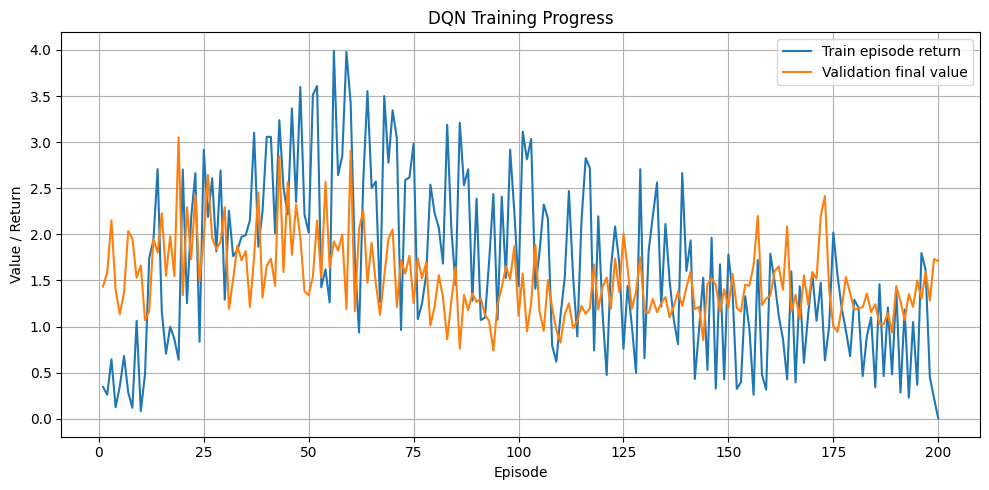

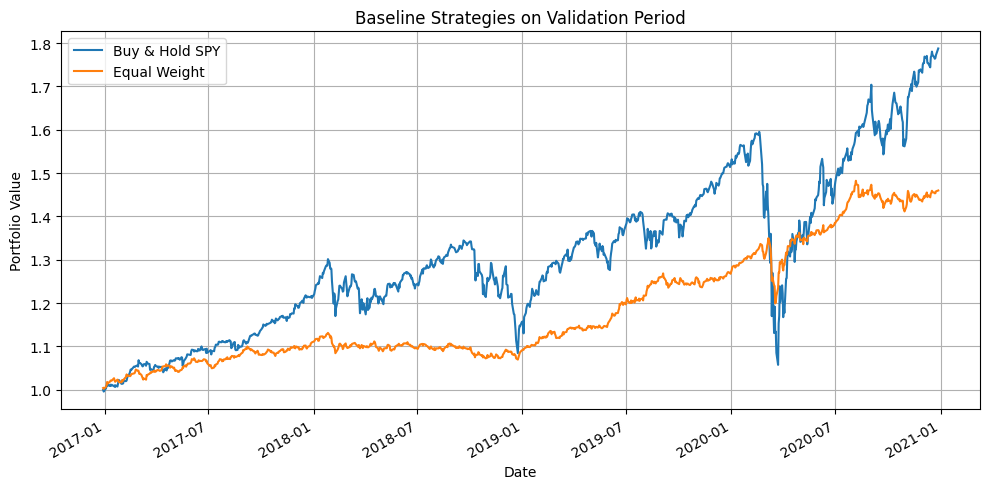

In [15]:
# ---- 0. Make src importable from this notebook (src/notebooks) ----
import os
import sys

# We are in src/notebooks, so:
#   ".."   = src
#   "../.." = project root (contains src, data, results)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

# ---- 1. Imports ----
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.baselines import (
    run_backtest,
    buy_and_hold_spy_weights,
    equal_weight_weights,
)
from src.data_processing import train_val_test_split


# ---- 2. Load log returns and compute train/val/test splits ----

# From src/notebooks, data is two levels up
log_rets_path = Path(project_root) / "data" / "processed" / "log_returns.csv"
log_rets = pd.read_csv(log_rets_path, index_col=0, parse_dates=True)

print("log_returns shape:", log_rets.shape)

train_dates, val_dates, test_dates = train_val_test_split(log_rets.index)

log_rets_train = log_rets.loc[log_rets.index.isin(train_dates)].copy()
log_rets_val = log_rets.loc[log_rets.index.isin(val_dates)].copy()
log_rets_test = log_rets.loc[log_rets.index.isin(test_dates)].copy()

print("Train / Val / Test sizes:",
      len(log_rets_train), len(log_rets_val), len(log_rets_test))


# ---- 3. Run baseline strategies on the validation set ----

spy_curve_val = run_backtest(log_rets_val, buy_and_hold_spy_weights)
ew_curve_val = run_backtest(log_rets_val, equal_weight_weights)

print("\nBaseline final values on VALIDATION period:")
print(f"  Buy & Hold SPY final value:   {spy_curve_val.iloc[-1]:.4f}")
print(f"  Equal-weight final value:      {ew_curve_val.iloc[-1]:.4f}")


# ---- 4. Load DQN training history ----

hist_path = Path(project_root) / "results" / "training_stats.csv"
if not hist_path.exists():
    raise FileNotFoundError(
        f"{hist_path} not found. "
        "Run `python -m src.train_dqn` from the project root first."
    )

history = pd.read_csv(hist_path)
print("\nTraining history tail:")
display(history.tail())


# ---- 5. Plot DQN training progress ----

plt.figure(figsize=(10, 5))
plt.plot(history["episode"], history["train_ep_return"], label="Train episode return")
plt.plot(history["episode"], history["val_final_value"], label="Validation final value")

plt.xlabel("Episode")
plt.ylabel("Value / Return")
plt.title("DQN Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ---- 6. (Optional) Plot validation baseline curves ----

plt.figure(figsize=(10, 5))
spy_curve_val.plot(label="Buy & Hold SPY")
ew_curve_val.plot(label="Equal Weight")

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Baseline Strategies on Validation Period")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Project root: c:\Users\zklu8\Documents\COMP 576\Portfolio-Allocator
Baseline final values on VALIDATION period:
  Buy & Hold SPY final value: 1.7874
  Equal-weight final value:    1.4597

DQN final value on VALIDATION period: 3.0535


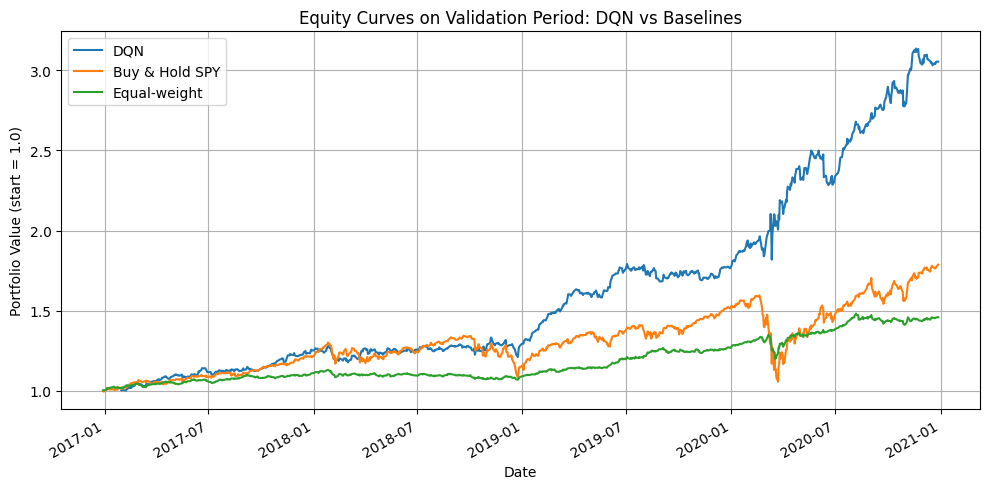

In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0. Make sure we can import from src/ ---
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in os.sys.path:
    os.sys.path.append(project_root)

print("Project root:", project_root)

from src.baselines import (
    run_backtest,
    buy_and_hold_spy_weights,
    equal_weight_weights,
)
from src.env_portfolio import PortfolioEnv, TICKERS
from src.dqn_agent import DQNAgent
from src.data_processing import train_val_test_split
from src.train_dqn import create_actions  # only imports function, won't retrain
import torch


# --- 1. Load log returns and split into train/val/test ---

log_rets_path = Path(project_root) / "data" / "processed" / "log_returns.csv"
log_rets = pd.read_csv(log_rets_path, index_col=0, parse_dates=True)

train_dates, val_dates, test_dates = train_val_test_split(log_rets.index)

log_rets_train = log_rets.loc[log_rets.index.isin(train_dates)].copy()
log_rets_val   = log_rets.loc[log_rets.index.isin(val_dates)].copy()
# log_rets_test = log_rets.loc[log_rets.index.isin(test_dates)].copy()  # for later


# --- 2. Baseline equity curves on VALIDATION set ---

spy_curve_val = run_backtest(log_rets_val, buy_and_hold_spy_weights)
ew_curve_val  = run_backtest(log_rets_val, equal_weight_weights)

print("Baseline final values on VALIDATION period:")
print(f"  Buy & Hold SPY final value: {spy_curve_val.iloc[-1]:.4f}")
print(f"  Equal-weight final value:    {ew_curve_val.iloc[-1]:.4f}")


# --- 3. Rebuild the DQN agent and load trained weights ---

actions = create_actions()

# Build an env just to get state_dim and n_actions correct
window_size = 20
cost = 0.0005
#cost = 0
env_for_dims = PortfolioEnv(
    log_returns=log_rets_train,
    actions=actions,
    window_size=window_size,
    cost=cost,
    episode_length=None,
    random_start=False,
)
state_dim = env_for_dims.state_dim
n_actions = actions.shape[0]

agent = DQNAgent(
    state_dim=state_dim,
    n_actions=n_actions,
    lr=1e-3,          # values here don't matter much for evaluation
    gamma=0.99,
    batch_size=64,
    buffer_capacity=50_000,
    min_buffer_size=1_000,
    epsilon_start=0.0,    # no exploration at eval time
    epsilon_end=0.0,
    epsilon_decay_steps=1,
    target_update_freq=1000,
)

model_path = Path(project_root) / "models" / "dqn_portfolio_best.pt"
state_dict = torch.load(model_path, map_location=agent.device)
agent.q_net.load_state_dict(state_dict)
agent.target_net.load_state_dict(state_dict)


def run_dqn_equity_curve(log_rets_period: pd.DataFrame) -> pd.Series:
    """Run the (greedy) DQN policy on a given period and record the equity curve."""
    env = PortfolioEnv(
        log_returns=log_rets_period,
        actions=actions,
        window_size=window_size,
        cost=cost,
        episode_length=None,
        random_start=False,
    )
    state = env.reset()
    done = False

    values = [env.value]
    dates  = [env.dates[env.t - 1]]

    while not done:
        action = agent.select_action(state, eval_mode=True)
        next_state, reward, done, info = env.step(action)
        values.append(env.value)
        dates.append(info["date"])
        state = next_state if next_state is not None else state

    # Drop the initial duplicate (we appended before the first step)
    return pd.Series(values[1:], index=dates[1:], name="DQN")


# --- 4. DQN equity curve on VALIDATION set ---

dqn_curve_val = run_dqn_equity_curve(log_rets_val)
print(f"\nDQN final value on VALIDATION period: {dqn_curve_val.iloc[-1]:.4f}")


# --- 5. Plot equity curves ---

plt.figure(figsize=(10, 5))
dqn_curve_val.plot(label="DQN")
spy_curve_val.plot(label="Buy & Hold SPY")
ew_curve_val.plot(label="Equal-weight")

plt.xlabel("Date")
plt.ylabel("Portfolio Value (start = 1.0)")
plt.title("Equity Curves on Validation Period: DQN vs Baselines")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
